In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from mlp.AISGPipeline import MLPipeline
sns.set()

pd.options.display.float_format = '{:,}'.format

# Summary of the Problem

We are tasked to predict traffic on any given time (interval in hours) given the following information:

    1. Holiday
    2. Temperature
    3. Rain occured in the hour
    4. Snow occured in the hour
    5. Percentage of cloud cover
    6. Current weather
    7. Weather description
    8. Date and time of the data collected
    
 ## Initial thoughts
 
 What do we expect to see from this EDA?
 
     1. Current weather should be the most important feature
     2. Mean of each month's traffic volume should not have high variance since the number of cars own should be roughly the same assuming normal usage of cars
     3. Clear skies should have the highest traffic volume for weather
     4. There is no correlation between lagged timesteps for traffic volume. Traffic volume is independent of its previous state
     5. Traffic volume should spike during peak periods
     
## Assumptions
    1. We are assuming the previous weather data has no impact on the prediction for the current traffic volume
    2. We are assuming the previous temperature has no impact on current traffic prediction
    3. Assuming weather description will have lesser impact on predictions than weather main since weather main is more generic

# Let's start with handling the data and checking for missing data

In [2]:
df = pd.read_csv('https://aisgaiap.blob.core.windows.net/aiap5-assessment-data/traffic_data.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,New Years Day,263.49,0.0,0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372


In [3]:
# Check for missing data
for i in range(len(df.columns)):
    print('Number of Null Data in ',df.columns[i],': ',sum(df[df.columns[i]].isnull()),sep='')

Number of Null Data in holiday: 0
Number of Null Data in temp: 0
Number of Null Data in rain_1h: 0
Number of Null Data in snow_1h: 0
Number of Null Data in clouds_all: 0
Number of Null Data in weather_main: 0
Number of Null Data in weather_description: 0
Number of Null Data in date_time: 0
Number of Null Data in traffic_volume: 0


# Feature Engineering

We will make use of feature engineering function from our ML pipeline class to create Day, DayOfWeek, Hour and Month values from the date_time column.

The default validation split is 0.3. It will be used in the feature engineering to weed out features that won't be useful for our analysis

In [4]:
data = MLPipeline(df)

Checking and removing variables with 0 variance
Removed thunderstorm with drizzle
Removed light snow
Removed Snow_1h
Env Variable Set: 48
Removed Categories:  ['thunderstorm with drizzle', 'light snow', 'Snow_1h']
Removed thunderstorm with drizzle
Removed light snow
Removed Snow_1h


# Hypothesis 1: The most important feature should be weather_main

Lets see the feature importance using tree.

The pipeline used above has already created the x dataset, converting weather_main and weather_description into one hot encoding.

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

data.y_train = data.y_train.reshape(len(data.y_train), )
clf = ExtraTreesClassifier(n_estimators=300).fit(data.x_train, data.y_train)
f_importance = clf.feature_importances_
importance_idx = np.argsort(f_importance)[::-1]

In [6]:
# print top 10 most important features

for i in range(10):
    f_idx = importance_idx[i]
    print(data.weather_categories_idx[f_idx],': ',round(f_importance[f_idx], 3), sep='')

Temperature: 0.409
Hour: 0.367
Day: 0.111
Day Of Week: 0.071
Month: 0.037
sky is clear: 0.002
Clear: 0.002
Clouds_all: 0.001
Sky is Clear: 0.001
scattered clouds: 0.001


Interesting find! Our initial assumption was that weather would be the biggest contributing factor for predicting traffic volume. Instead, we find that the top 2 features are Temperature and Hour of the day. 

In fact, Temperature and Hour contribute to around 70% of the gini index. The assumption was that the general weather would make determine the volume of the traffic. For example, even though clear skies and drizzle may not differ much in temperature, people may be more inclined to drive in clear skies as it's easier to than drizzling. Or between drizziling and raining, which temperature shouldn't differ by much, we believe people are more inclined to drive when it's drizzling compared to raining because it's easier to drive.

Apparently our assumption was wrong. Let's look further to see what we can find.

# Plotting the distribution for Temperature and Traffic Volume

Temperature Mean:  278.9763521521055
Temperature Standard Deviation:  13.321681950146273


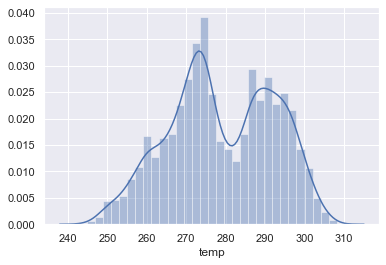

In [7]:
sns.distplot(df.temp)
temp_mean = np.mean(df.temp)
temp_std = np.std(df.temp)

print('Temperature Mean: ', temp_mean)
print('Temperature Standard Deviation: ', temp_std)

Traffic Volume Mean:  3286.762
Traffic Colume Standard Deviation:  2028.204


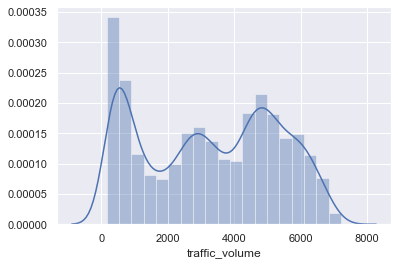

In [8]:
# Plotting histogram for traffic volume

sns.distplot(df.traffic_volume)
traffic_mean = np.mean(df.traffic_volume)
traffic_std = np.std(df.traffic_volume)

print('Traffic Volume Mean: ', round(traffic_mean, 3))
print('Traffic Colume Standard Deviation: ', round(traffic_std, 3))

# Plotting the trend of temperature with traffic volume by month, scaled between 0 to 1 

In [9]:
# Plotting the mean of each month's temperature with each month's mean traffic volume
# we scale each data to its maximum value to see the relative change

month_temp = df.groupby('Month').mean()

temp_max = month_temp['temp'].max()
temp_min = month_temp['temp'].min()
temp_range = temp_max - temp_min

traffic_max = month_temp['traffic_volume'].max()
traffic_min = month_temp['traffic_volume'].min()
traffic_range = traffic_max - traffic_min

month_temp['temp'] = (month_temp['temp']-temp_min)/temp_range
month_temp['traffic_volume'] = (month_temp['traffic_volume']-traffic_min)/traffic_range

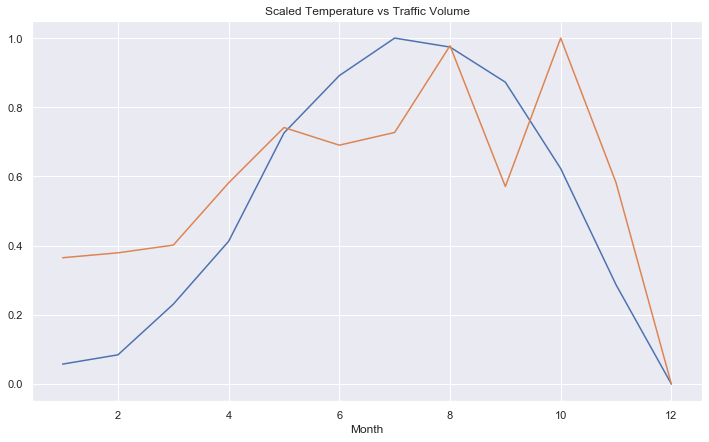

In [10]:
plt.figure(figsize=(12,7))
plt.title('Scaled Temperature vs Traffic Volume')
plt.plot(month_temp[['temp', 'traffic_volume']])
plt.xlabel('Month')
plt.show()
plt.close()

## Conclusion on this finding

Just as we expected from the feature importance analysis, there's a strong correlation between temperature and traffic volume. The higher the temperature, the higher the traffic volume. 

One highly plausible explanation is that the higher the temperature, the more uncomfortable it is to travel without a car. Therefore there's more car usage, increasing traffic volume.

\
\
\
\
\
\
time for the next hypothesis

# Hypothesis 2: Average of each month's traffic volume should NOT deviate too much as the number of cars own should be roughly the same, if not increasing assuming stable economic growth

To have a better idea, let's look at car sales from 2013 in the US.

From the following website: http://carsalesbase.com/us-car-sales-data/, it says car sales from **2012** was **14,492,398** and for **2013** it's **15,582,136**.

|Year|Sales|
|----|----------|
|2012|14,492,398|
|2013|15,582,136|
|2014|16,531,070|

From a logical perspective, more car sales should lead to more traffic usage. Let's see what happens when we plot the mean traffic volume by month.

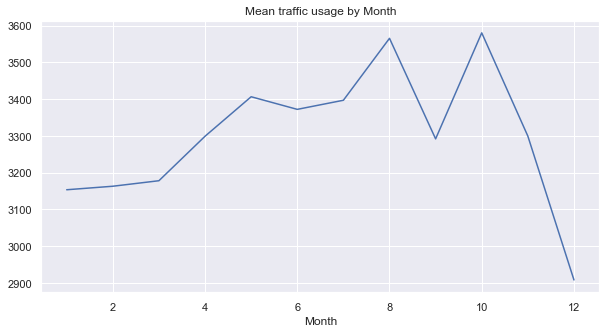

In [11]:
month_vol = df[['Month', 'traffic_volume']].groupby('Month').mean()
plt.figure(figsize=(10,5))
plt.title('Mean traffic usage by Month')
plt.plot(month_vol)
plt.xlabel('Month')
plt.show()
plt.close()

Seems like there's a consistent upward at the first half of the year and a sharp spike down towards the end. This is somewhat expected as we have shown that temperature has a strong correlation to traffic volume. As they were reaching the end of the year, it's moving towards winter and the traffic volume should decline.

Let's plot the median of each month and see what it shows

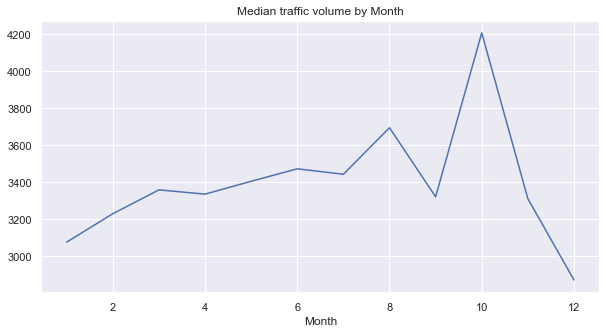

In [12]:
month_vol = df[['Month', 'traffic_volume']].groupby('Month').median()
plt.figure(figsize=(10,5))
plt.title('Median traffic volume by Month')
plt.plot(month_vol)
plt.xlabel('Month')
plt.show()
plt.close()

Now we have a plot that's consistent with that we know should make sense. The median traffic volume consistently increase throughout the year except for the end when the average temperature is much colder.

## Conclusion on this finding

Based on this, we can assume higher car sales volume leads to higher traffic usage. If we were to dig further, we should find a correlation between car sales and traffic volume. Nothing really surprising here. On top of that, it also shows that temperature plays a much more important role than car sales.

\
\
\
\
\
Time for the next hypothesis

# Hypothesis 3: Clear Skies should have the highest traffic volume as it is the best weather to go out and be outdoors

Better weather leads to more inclination to go out and be outdoors. Bad weather leads to lesser inclination to be outdoors therefore lower traffic volume.

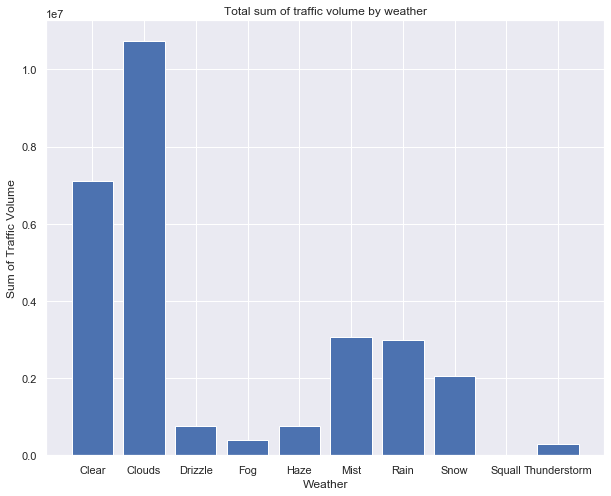

              traffic_volume
weather_main                
Clear                7094701
Clouds              10731911
Drizzle               751582
Fog                   387955
Haze                  760368
Mist                 3077748
Rain                 2998275
Snow                 2065873
Squall                  4036
Thunderstorm          304963


In [13]:
# Sum of traffic volume by weather

weather_sum = df[['weather_main','traffic_volume']].groupby(['weather_main']).sum()

plt.figure(figsize=(10,8))
plt.title('Total sum of traffic volume by weather')
plt.xlabel('Weather')
plt.ylabel('Sum of Traffic Volume')
plt.bar(weather_sum.index, weather_sum.traffic_volume)
plt.show()
plt.close()

print(weather_sum)

Although clear weather is 2nd is the total sum of traffic usage, it's significantly behind cloud weather. It's too early to make any conclusion. Let's dive deeper.

Let's look at the number of occurences for each weather

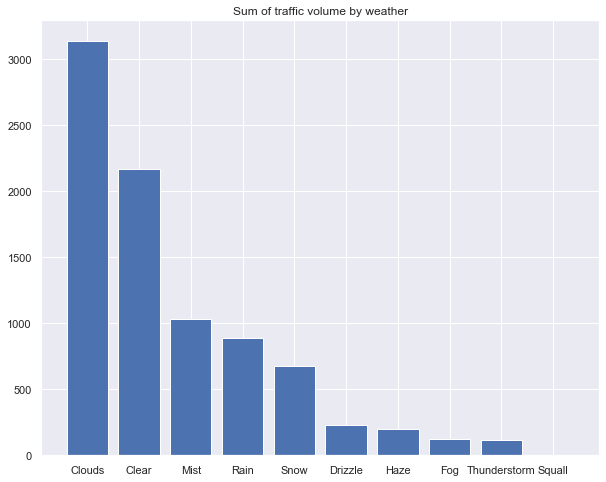

Clouds          3136
Clear           2169
Mist            1034
Rain             889
Snow             674
Drizzle          230
Haze             201
Fog              123
Thunderstorm     114
Squall             3
Name: weather_main, dtype: int64


In [14]:
# Occurences of each weather in the dataset

weather_count = df.weather_main.value_counts()
plt.figure(figsize=(10,8))
plt.title('Sum of traffic volume by weather')
plt.bar(weather_count.index, weather_count)
plt.show()
plt.close()

print(df['weather_main'].value_counts())

It seems like clouds has the highest occurences in the entire dataset. This could have led to the total sum being the most. Let's use the mean to find out what it tells us.

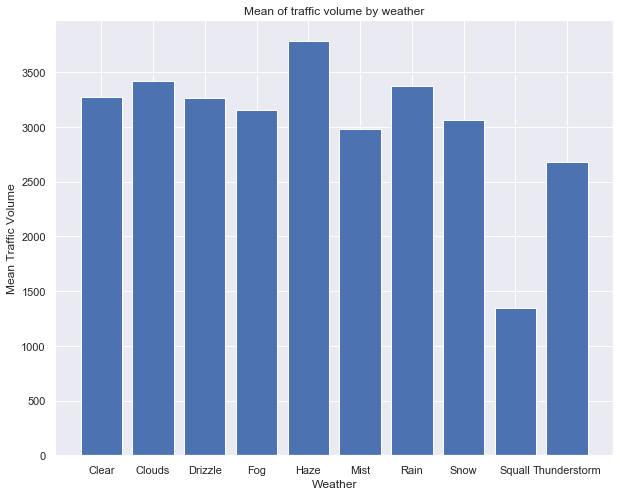

              traffic_volume
weather_main                
Haze                3,782.93
Clouds              3,422.17
Rain                3,372.64
Clear               3,270.95
Drizzle             3,267.75
Fog                 3,154.11
Snow                3,065.09
Mist                2,976.55
Thunderstorm        2,675.11
Squall              1,345.33


In [15]:
# Mean of traffic volume for each weather

weather_sum = df[['weather_main','traffic_volume']].groupby(['weather_main']).mean()

plt.figure(figsize=(10,8))
plt.title('Mean of traffic volume by weather')
plt.xlabel('Weather')
plt.ylabel('Mean Traffic Volume')
plt.bar(weather_sum.index, weather_sum.traffic_volume)
plt.show()
plt.close()

# print volume sorted by highest mean to lowest

print(round(weather_sum.sort_values('traffic_volume', ascending=False), 2))

A surprising find! We thought the highest mean would be Clouds and Clear, but they are ranked 2nd and 4th behind Haze and Rain. This could be evidence that majority of traffic volume is contributed by **utility** usage instead of **recreational** usage. In other words, people are more likely to drive because the weather is bad instead of using it for recreational use.

Since the top 5 rankings are Haze, Clouds, Rain, Clear and Drizzle, it could be infered that Haze causes the most discomfort to be outdoors, therefore more people drive to get to their destination. People see clouds as an indication of possible rain, therefore they drive just in case rain happens. Clear weather tells us people still drive for recreational use, but it's not as important as driving to avoid being in the middle of a bad weather.

This can be further confirmed by our initial finding that hotter temperature causes more traffic usage.

### Conclusion for this finding

Our initial belief that better weather leads to more recreational activities which should lead to higher traffic usage wasn't validated by what we found. The utility of NOT walking or being in the middle of a bad weather has a larger impact on whether people decide to drive.

# Hypothesis 4: Traffic volume does not have strong autocorrelation. Lagged values have minimal value in helping to predict traffic volume

Let's investigate to determine whether traffic volume can be predicted with time series analysis.

We shall start with performing an autocorrelation study.

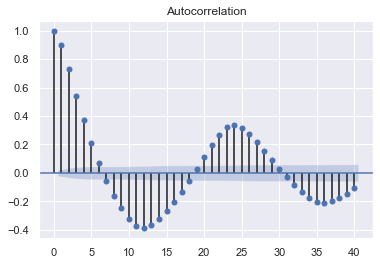

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

traffic_vol = np.array(df.traffic_volume)

plot_acf(traffic_vol)
plt.show()

The correlation values of every lagged value are significantly outside of the confidence interval, suggesting that there's nearly no correlation between lagged values. Let's use partial autocorrelation to conclusive decide whether a time series model would be useful for predicting traffic volume.

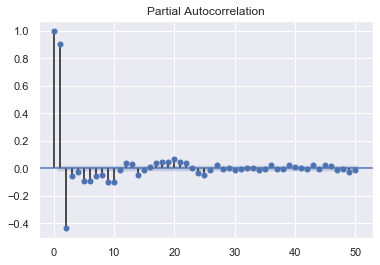

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(traffic_vol, lags=50)
plt.show()

Again, the correlation values are significantly outside the confidence interval.

### Conclusion
Time series models like ARIMA and ARMA models would not work well with this task.

# Hypothesis 5: Traffic volume spike at peak hour of each day, caused by starting of the work day and ending of the work day

We want to see if the hour of the day have a huge impact in traffic volume.

Let's group traffic volume by hours of the day.

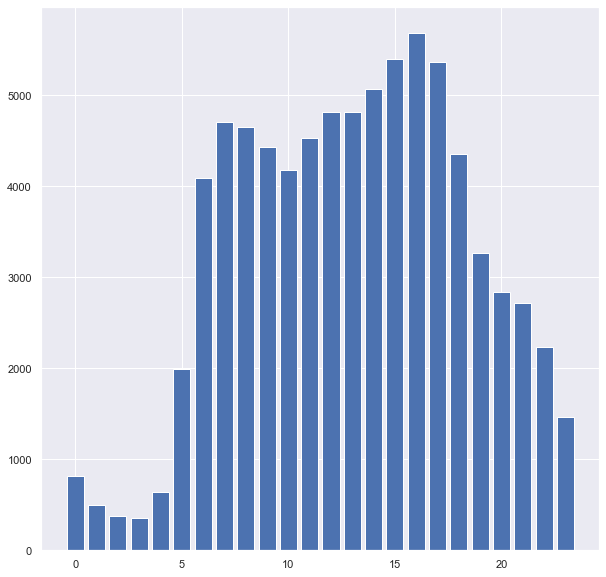

In [18]:
# Plotting the mean traffic volume by hour 

hour_mean = round(df[['Hour','traffic_volume']].groupby(['Hour']).mean(), 2)
plt.figure(figsize=(10, 10))
plt.bar(hour_mean.index, hour_mean.traffic_volume)
plt.show()
plt.close()

In [19]:
hour_mean.sort_values('traffic_volume', ascending=False)

,traffic_volume
Hour,
16,"5,688.03"
15,"5,395.41"
17,"5,362.01"
14,"5,064.69"
12,"4,819.25"
13,"4,816.51"
7,"4,710.86"
8,"4,651.71"
11,"4,532.34"


As expected, traffic spikes between 15 to 17 hour each day and is at the lowest around midnight, between 23-5 hour.

Let's look at the median value and see if it tells us another story.

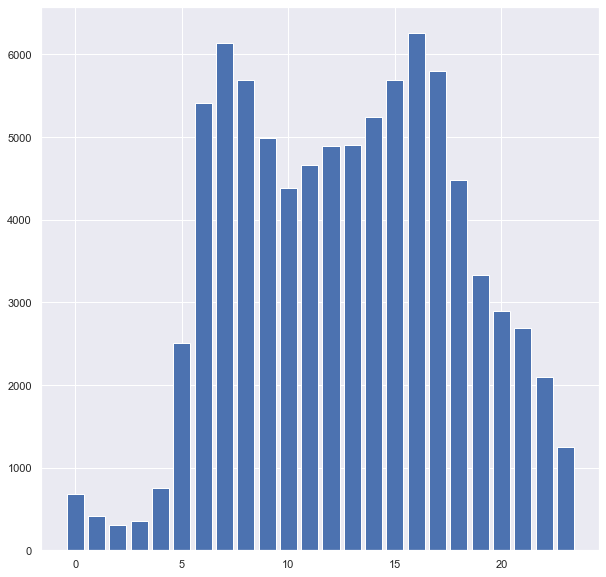

In [20]:
# Plotting the median traffic volume by hour 

hour_median = df[['Hour','traffic_volume']].groupby(['Hour']).median()
plt.figure(figsize=(10, 10))
plt.bar(hour_median.index, hour_median.traffic_volume)
plt.show()
plt.close()

In [21]:
hour_median.sort_values('traffic_volume', ascending=False)

,traffic_volume
Hour,
16,"6,264.0"
7,"6,136.0"
17,"5,794.5"
8,"5,689.5"
15,"5,686.0"
6,"5,413.0"
14,"5,245.0"
9,"4,988.5"
13,"4,903.5"


This time it gives us a better picture. The top 6 hours consists of the intervals between 6-8 and 15-17. A reasonable assumption is that 6-8 is the period when people are driving to work and 15-17 is the period when people are driving home from work. The sharpest drop is between 0-4, during the midnight period which is to be expected.

Let's plot a box and whiskers diagram to visualize the distribution of each hour.

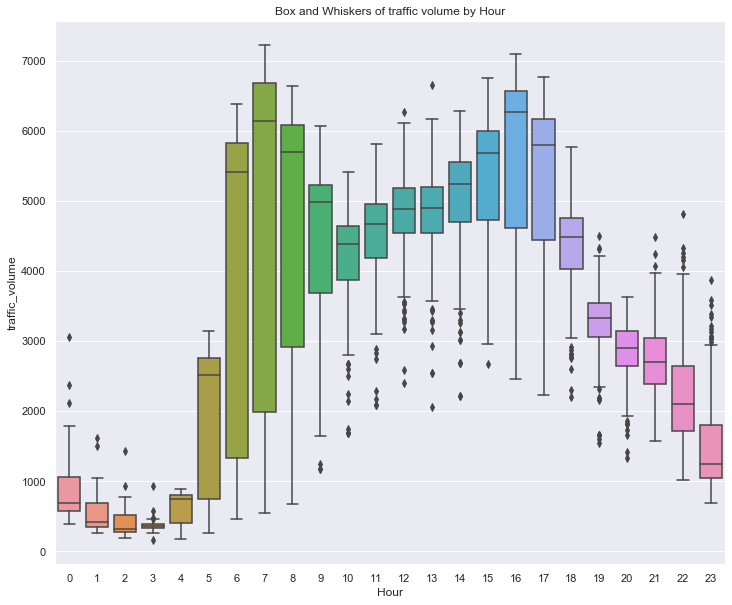

In [22]:
box_data = df[['DayOfWeek', 'Month', 'Hour', 'traffic_volume']].copy()

plt.figure(figsize=(12,10))
plt.title('Box and Whiskers of traffic volume by Hour')
sns.boxplot(x='Hour', y='traffic_volume', data=box_data)

Looks like there's a huge range of distribution for interval 5-7. One possible cause is the sharp dip in traffic volume in November and December. Let's remove them and see how the plot looks.

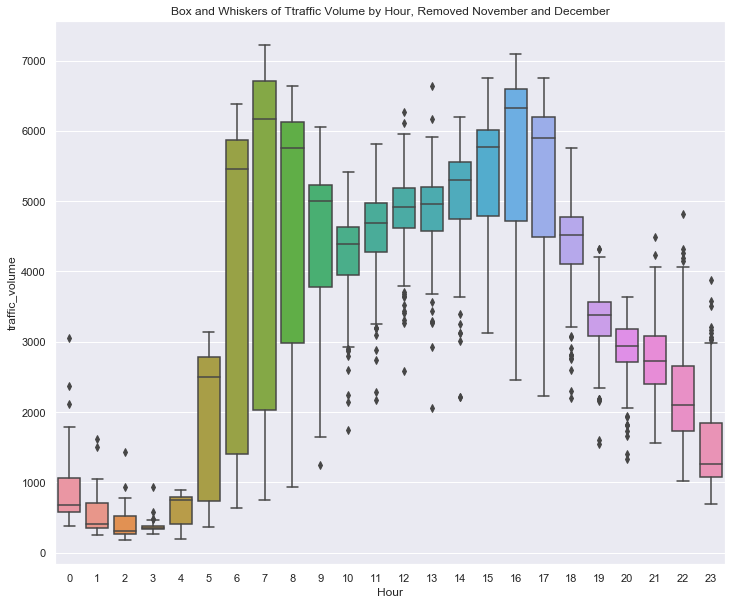

In [23]:
box_data = box_data[box_data.Month != 12]
box_data = box_data[box_data.Month != 11]

plt.figure(figsize=(12,10))
plt.title('Box and Whiskers of Ttraffic Volume by Hour, Removed November and December')
sns.boxplot(x='Hour', y='traffic_volume', data=box_data)

It still looks skewered. Lets remove Saturdays and Sundays and see how it looks.

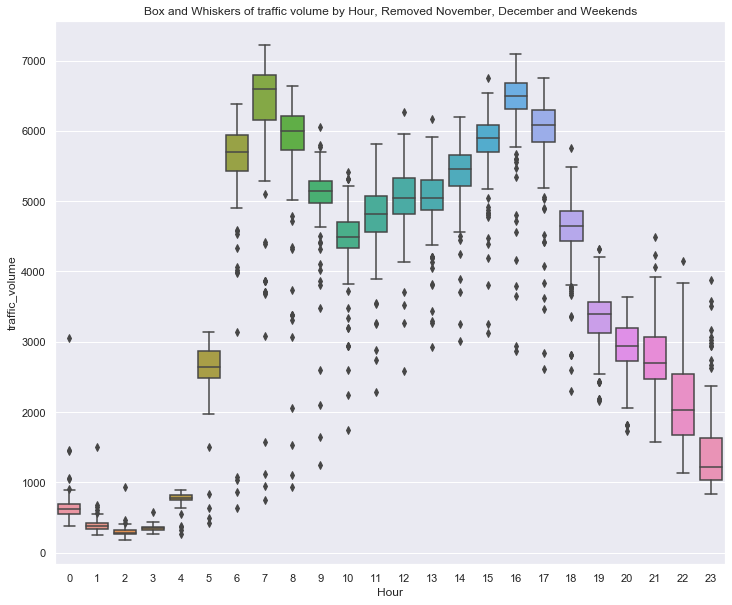

In [24]:
box_data = box_data[box_data.DayOfWeek != 5]
box_data = box_data[box_data.DayOfWeek != 6]

plt.figure(figsize=(12,10))
plt.title('Box and Whiskers of traffic volume by Hour, Removed November, December and Weekends')
sns.boxplot(x='Hour', y='traffic_volume', data=box_data)

The plot looks much more consistent now! This aligns with our earlier assumption that majority of the traffic volume is caused by people driving to and fro work. Removing weekends shows us a much clearer picture of how the hours impact the traffic volume. 

# Final Conclusion

We have learnt several important things about this dataset, namely:

    1. Temperature is the most important factor in determining the traffic volume
    2. Increased car sales leads to increase in traffic volume
    3. Traffic volume is driven by bad weather more than good weather. People tend to drive more as a utility function more than recreational or convenience use.
    4. There is no correlation between lagged traffic volume that can be used for predicting future traffic volume
    5. Peak period when people are driving to and fro work contributes to the most traffic volume.
    